# Predicting AirBnB Prices using Carto open data and Machine Learning

![alt text for screen readers](risk_image.png "Predicted AirBnB prices on the left, actual prices on the right.")

# Libraries / ライブラリー

In [ ]:
# Install packages
# パッケージのインストール
#!pip install pydeck-carto geopandas carto-auth[carto-dw] db_dtypes -q xgboost category-encoders numpy shap matplotlib seaborn

In [47]:
# Carto / GoogleBigQuery
import pydeck as pdk
import pydeck_carto as pdkc
from carto_auth import CartoAuth
from google.cloud import bigquery

# Plotting / プロット
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Analysis / 分析
import math
import numpy as np
import pandas as pd
import geopandas as gpd

# Machine Learning / 機械学習
import xgboost as xgb
import category_encoders as ce
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    LeaveOneOut,
    cross_val_score,
    train_test_split,
)

# Authentication / 認証

In [114]:
# Authenticate Carto
# Cartoを認証する
carto_auth = CartoAuth.from_oauth()
carto_dw_client = carto_auth.get_carto_dw_client()

In [117]:
# Determine the user's dataset IDs
# ユーザーのデータセットIDを決定する
dataset_id = 'shared_us'
tables = carto_dw_client.list_tables(dataset_id)
carto_user_id = list(tables)[0].project.split('-')[-1]

cdw_dataset = f"carto-dw-ac-{carto_user_id}"
cdo_dataset =  f"carto-data.ac_{carto_user_id}"

print(f"Carto Data Warehouse Dataset: {cdw_dataset}")
print(f"Carto Data Warehouse Dataset: {cdo_dataset}")

Carto Data Warehouse Dataset: carto-dw-ac-zn8l36fh
Carto Data Warehouse Dataset: carto-data.ac_zn8l36fh


# Accessing Data / データへのアクセス

In [118]:
# List datasets in Carto Data Warehouse
# Cartoデータウェアハウスのデータセットの表示
datasets = list(carto_dw_client.list_datasets())

if datasets:
    print("Datasets in CARTO Data Warehouse:")
    for dataset in datasets:
        print("\t{}".format(dataset.dataset_id))
else:
    print("CARTO Data Warehouse project does not contain any datasets.")

Datasets in CARTO Data Warehouse:
	private_christopher_kyed_3_a1907fcc
	shared
	shared_us
	workflows_temp_christopher_kyed_3_a1907fcc
	workflows_temp_christopher_kyed_3_a1907fcc_us


In [119]:
# List tables in chosen dataset
# 選択したデータセットのテーブルをリストアップする
dataset_id = 'shared_us'
tables = carto_dw_client.list_tables(dataset_id)  # Make an API request.

print("Tables contained in '{}':".format(dataset_id))
for table in tables:
    print("{}.{}.{}".format(table.project, table.dataset_id, table.table_id))

Tables contained in 'shared_us':
carto-dw-ac-zn8l36fh.shared_us.london_listings_2023
carto-dw-ac-zn8l36fh.shared_us.london_listings_2023_joined
carto-dw-ac-zn8l36fh.shared_us.london_listings_2023_predicted


In [120]:
# Query the London Listings table and visualize as GeoDataFrame
# London Listingsテーブルを照会し、GeoDataFrameとして可視化する。
table = carto_dw_client.get_table(f"{cdw_dataset}.shared_us.london_listings_2023_joined")
gdf = carto_dw_client.list_rows(table).to_geodataframe(
    geography_column="geom", create_bqstorage_client=False
)
display(gdf.head())

,h3_geo,h3,geom,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,...,female_joined,male_joined,leisure_joined,tourism_joined,transportation_joined,urbanity_joined,elevation_joined,work_zone,work_zone_specific,mobility
0,"POLYGON ((-0.112251780138984 51.340470586934, ...",88194ac043fffff,POINT (-0.11542 51.33853),Croydon,Entire home/apt,50,2,0,None,0,...,1683.597980,1582.383419,68,1,38,High_density_urban,86.999451,City and business parks,Big city life,0.100075
1,"POLYGON ((-0.112251780138984 51.340470586934, ...",88194ac043fffff,POINT (-0.11544 51.33907),Croydon,Private room,53,1,0,None,244,...,1683.597980,1582.383419,68,1,38,High_density_urban,86.999451,City and business parks,Big city life,0.100075
2,"POLYGON ((-0.189477261893829 51.3607104259434,...",88194ac14bfffff,POINT (-0.19021 51.36049),Sutton,Entire home/apt,221,2,10,1.34000000000000000000000000000000000000,64,...,3049.662862,2866.323197,13,1,34,High_density_urban,72.861415,City and business parks,Big city life,0.132090
3,"POLYGON ((-0.189477261893829 51.3607104259434,...",88194ac14bfffff,POINT (-0.19099 51.35987),Sutton,Entire home/apt,107,3,21,0.24000000000000000000000000000000000000,325,...,3049.662862,2866.323197,13,1,34,High_density_urban,72.861415,City and business parks,Big city life,0.132090
4,"POLYGON ((-0.221730330875738 51.3591716768889,...",88194ac16bfffff,POINT (-0.21853 51.35702),Sutton,Private room,65,2,31,0.32000000000000000000000000000000000000,351,...,642.919993,608.721363,0,1,7,High_density_urban,54.483877,City and business parks,Big city life,0.103522


# Visualizing Data / データの可視化

## CARTO Data Warehouse / CARTOデータウェアハウス

In [10]:
# Register CartoLayer in pydeck
# pydeckにCartoLayerを登録する。
pdkc.register_carto_layer()

# Render first CartoLayer CartoLayer
# 最初の CartoLayer CartoLayer をレンダリングする。
layer = pdk.Layer(
    "CartoLayer",
    data=f"SELECT geom, price FROM `{cdw_dataset}.shared_us.london_listings_2023_joined`",
    type_=pdkc.MapType.QUERY,
    connection=pdkc.CartoConnection.CARTO_DW,
    credentials=pdkc.get_layer_credentials(carto_auth),
    point_radius_min_pixels=2.5,
    get_fill_color=pdkc.styles.color_bins(
        "price", [0, 100, 200, 300, 400, 500], "PinkYl"
    ),
    get_line_color=[0, 0, 0, 100],
)

# Set initial viewing location/zoom/angle
# 初期表示位置/ズーム/アングルを設定する
view_state = pdk.ViewState(
    latitude=51.50071697877869,
    longitude=-0.12461158468895285,
    zoom=8
)

# Initialize map
# マップの初期化
pdk.Deck(layer, map_style=pdk.map_styles.ROAD, initial_view_state=view_state).to_html(
    iframe_height=800
)

# Data preparation / データ準備

## Data cleaning / データクリーニング

In [121]:
# Load joined Carto Workflow table into a DataFrame
# 結合されたCarto WorkflowテーブルをDataFrameにロードする。
table = carto_dw_client.get_table(
    f"{cdw_dataset}.shared_us.london_listings_2023_joined"
)
gdf_load = carto_dw_client.list_rows(table).to_geodataframe(
    geography_column="geom", create_bqstorage_client=False
)

# Create an index on the table
# テーブルにインデックスを作成する
idx = "index"
gdf_load = gdf_load.reset_index()
gdf_load = gdf_load.set_index(idx)
gdf_load

# Drop geometry columns
# ジオメトリの列を削除する
gdf_clean = gdf_load.drop(['h3_geo', 'h3', 'geom', 'h3_joined'], axis=1)

# Rename columns created by join in workflow
# ワークフローで結合によって作成された列の名前を変更する
gdf_clean.rename(columns={"population_joined": "population",
                          "leisure_joined": "lesiure",
                          "tourism_joined": "tourism",
                          "transportation_joined": "transportation",
                          "urbanity_joined": "urbanity",
                          "female_joined": "female",
                          "male_joined": "male",
                          "elevation_joined": "elevation"}, inplace=True)
gdf_clean

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,number_of_reviews_ltm,population,female,male,lesiure,tourism,transportation,urbanity,elevation,work_zone,work_zone_specific,mobility
index,,,,,,,,,,,,,,,,,,,
0,Croydon,Entire home/apt,50,2,0,None,0,0,3265.981399,1683.597980,1582.383419,68,1,38,High_density_urban,86.999451,City and business parks,Big city life,0.100075
1,Croydon,Private room,53,1,0,None,244,0,3265.981399,1683.597980,1582.383419,68,1,38,High_density_urban,86.999451,City and business parks,Big city life,0.100075
2,Sutton,Entire home/apt,221,2,10,1.34000000000000000000000000000000000000,64,10,5915.986059,3049.662862,2866.323197,13,1,34,High_density_urban,72.861415,City and business parks,Big city life,0.132090
3,Sutton,Entire home/apt,107,3,21,0.24000000000000000000000000000000000000,325,14,5915.986059,3049.662862,2866.323197,13,1,34,High_density_urban,72.861415,City and business parks,Big city life,0.132090
4,Sutton,Private room,65,2,31,0.32000000000000000000000000000000000000,351,2,1251.641355,642.919993,608.721363,0,1,7,High_density_urban,54.483877,City and business parks,Big city life,0.103522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81750,Enfield,Entire home/apt,200,7,0,None,365,0,4434.785557,2271.190336,2163.595221,0,1,13,High_density_urban,21.250181,Metro suburbs,Self-employed tradespeople in multicultural me...,0.097842
81751,Enfield,Private room,57,2,2,2.00000000000000000000000000000000000000,337,2,1512.703085,774.384732,738.318353,1,0,2,High_density_urban,17.120275,Metro suburbs,Self-employed tradespeople in multicultural me...,0.089394
81752,Enfield,Private room,80,2,0,None,338,0,1512.703085,774.384732,738.318353,1,0,2,High_density_urban,17.120275,Metro suburbs,Self-employed tradespeople in multicultural me...,0.089394


In [122]:
# Check data types for each column
# 各列のデータ型をチェックする
gdf_clean.dtypes['reviews_per_month']

dtype('O')

In [124]:
# Force data type for 'reviews_per_month' variables
# 変数のデータ型を強制する
for num in ['reviews_per_month']:
  gdf_clean[num] = gdf_clean[num].astype('float64')
gdf_clean

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,number_of_reviews_ltm,population,female,male,lesiure,tourism,transportation,urbanity,elevation,work_zone,work_zone_specific,mobility
index,,,,,,,,,,,,,,,,,,,
0,Croydon,Entire home/apt,50,2,0,NaN,0,0,3265.981399,1683.597980,1582.383419,68,1,38,High_density_urban,86.999451,City and business parks,Big city life,0.100075
1,Croydon,Private room,53,1,0,NaN,244,0,3265.981399,1683.597980,1582.383419,68,1,38,High_density_urban,86.999451,City and business parks,Big city life,0.100075
2,Sutton,Entire home/apt,221,2,10,1.34,64,10,5915.986059,3049.662862,2866.323197,13,1,34,High_density_urban,72.861415,City and business parks,Big city life,0.132090
3,Sutton,Entire home/apt,107,3,21,0.24,325,14,5915.986059,3049.662862,2866.323197,13,1,34,High_density_urban,72.861415,City and business parks,Big city life,0.132090
4,Sutton,Private room,65,2,31,0.32,351,2,1251.641355,642.919993,608.721363,0,1,7,High_density_urban,54.483877,City and business parks,Big city life,0.103522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81750,Enfield,Entire home/apt,200,7,0,NaN,365,0,4434.785557,2271.190336,2163.595221,0,1,13,High_density_urban,21.250181,Metro suburbs,Self-employed tradespeople in multicultural me...,0.097842
81751,Enfield,Private room,57,2,2,2.00,337,2,1512.703085,774.384732,738.318353,1,0,2,High_density_urban,17.120275,Metro suburbs,Self-employed tradespeople in multicultural me...,0.089394
81752,Enfield,Private room,80,2,0,NaN,338,0,1512.703085,774.384732,738.318353,1,0,2,High_density_urban,17.120275,Metro suburbs,Self-employed tradespeople in multicultural me...,0.089394


## Null values

In [128]:
gdf_selected = gdf_clean.copy()
# Display null values
# ヌル値を表示する
display(gdf_selected.isnull().sum())

# Fill remaining null values with 0
# 残りのヌル値を0で埋める
gdf_selected = gdf_selected.fillna(0)
display(gdf_selected.isnull().sum())

neighbourhood                0
room_type                    0
price                        0
minimum_nights               0
number_of_reviews            0
reviews_per_month        20589
availability_365             0
number_of_reviews_ltm        0
population                   0
female                       0
male                         0
lesiure                      0
tourism                      0
transportation               0
urbanity                     0
elevation                    0
work_zone                    0
work_zone_specific           0
mobility                     0
dtype: int64

neighbourhood            0
room_type                0
price                    0
minimum_nights           0
number_of_reviews        0
reviews_per_month        0
availability_365         0
number_of_reviews_ltm    0
population               0
female                   0
male                     0
lesiure                  0
tourism                  0
transportation           0
urbanity                 0
elevation                0
work_zone                0
work_zone_specific       0
mobility                 0
dtype: int64

## Outliers

In [129]:
# Use df.describe to check percentiles for each numerical colummn
# df.describeを使って各数値列のパーセンタイルをチェックする
gdf_selected.describe(percentiles=[.25, .5, .75, .95, .99])

,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,number_of_reviews_ltm,population,female,male,lesiure,tourism,transportation,elevation,mobility
count,81755.0,81755.0,81755.0,81755.000000,81755.0,81755.0,81755.000000,81755.000000,81755.000000,81755.0,81755.0,81755.0,81755.000000,81755.000000
mean,187.545508,5.64845,17.942695,0.726043,119.304948,5.907859,8519.053966,4314.552049,4204.501917,36.522904,5.366767,52.397505,25.927212,0.097697
std,477.538813,22.999768,42.247332,1.225547,133.869156,12.968135,3745.084105,1893.506353,1851.893584,51.778037,8.736367,41.005148,17.123181,0.030673
min,0.0,1.0,0.0,0.000000,0.0,0.0,10.962097,5.614028,5.348069,0.0,0.0,0.0,3.187225,0.021189
25%,61.0,1.0,0.0,0.000000,0.0,0.0,5634.368035,2850.400636,2775.946229,5.0,0.0,21.0,13.934549,0.076423
50%,110.0,2.0,4.0,0.230000,59.0,1.0,8637.996885,4382.029153,4244.864379,18.0,2.0,42.0,20.383837,0.092812
75%,198.0,4.0,16.0,0.950000,245.0,6.0,11479.420325,5794.092626,5692.861227,47.0,6.0,71.0,32.040702,0.113142
95%,514.3,14.0,82.0,3.120000,361.0,29.0,14366.825070,7242.045327,7124.779743,149.0,26.0,150.0,60.592572,0.148096
99%,1570.0,90.0,209.0,5.680000,365.0,61.0,15413.859685,7837.219531,7576.640154,233.0,39.0,165.0,89.080218,0.192593
max,58564.0,1125.0,1425.0,50.500000,365.0,531.0,18360.206098,9331.315897,9028.890201,427.0,56.0,187.0,215.278351,0.321531


In [133]:
# Remove data from selected columns not within the 99th percentile
# 選択された列から99パーセンタイル以内のデータを削除する。
gdf_selected = gdf_selected[gdf_selected['price'] >= 1]
gdf_selected = gdf_selected[gdf_selected['price'] <= 1570.000000]
gdf_selected = gdf_selected[gdf_selected['minimum_nights'] <= 90]
gdf_selected = gdf_selected[gdf_selected['number_of_reviews'] <= 209.000000]
gdf_selected = gdf_selected[gdf_selected['number_of_reviews_ltm'] <= 61.0]
gdf_selected

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,number_of_reviews_ltm,population,female,male,lesiure,tourism,transportation,urbanity,elevation,work_zone,work_zone_specific,mobility
index,,,,,,,,,,,,,,,,,,,
0,Croydon,Entire home/apt,50,2,0,0.00,0,0,3265.981399,1683.597980,1582.383419,68,1,38,High_density_urban,86.999451,City and business parks,Big city life,0.100075
1,Croydon,Private room,53,1,0,0.00,244,0,3265.981399,1683.597980,1582.383419,68,1,38,High_density_urban,86.999451,City and business parks,Big city life,0.100075
2,Sutton,Entire home/apt,221,2,10,1.34,64,10,5915.986059,3049.662862,2866.323197,13,1,34,High_density_urban,72.861415,City and business parks,Big city life,0.132090
3,Sutton,Entire home/apt,107,3,21,0.24,325,14,5915.986059,3049.662862,2866.323197,13,1,34,High_density_urban,72.861415,City and business parks,Big city life,0.132090
4,Sutton,Private room,65,2,31,0.32,351,2,1251.641355,642.919993,608.721363,0,1,7,High_density_urban,54.483877,City and business parks,Big city life,0.103522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81750,Enfield,Entire home/apt,200,7,0,0.00,365,0,4434.785557,2271.190336,2163.595221,0,1,13,High_density_urban,21.250181,Metro suburbs,Self-employed tradespeople in multicultural me...,0.097842
81751,Enfield,Private room,57,2,2,2.00,337,2,1512.703085,774.384732,738.318353,1,0,2,High_density_urban,17.120275,Metro suburbs,Self-employed tradespeople in multicultural me...,0.089394
81752,Enfield,Private room,80,2,0,0.00,338,0,1512.703085,774.384732,738.318353,1,0,2,High_density_urban,17.120275,Metro suburbs,Self-employed tradespeople in multicultural me...,0.089394


## Choosing Variables

In [ ]:
"""
--CATEGORICAL VARIABLES--
neighbourhood
room_type
urbanity
work_zone
work_zone_specific

--NUMERICAL VARIABLES--
minimum_nights
number_of_reviews
availability_365
number_of_reviews_ltm
reviews_per_month
transportation
tourism
lesiure
population
male
female
mobility

--TARGET--
price
"""

In [135]:
# Declare numerical, categorical and target variables
# 数値変数、カテゴリー変数、ターゲット変数の宣言
categorical_variables = [
    "neighbourhood",
    "room_type",
    "urbanity",
    "work_zone_specific"
]

numerical_variables = [
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "availability_365",
    "population",
    "lesiure",
    "tourism",
    "transportation",
    "mobility",
]

target = "price"

# Force data types for our variables
# 変数のデータ型を強制する
for cat in categorical_variables:
  gdf_selected[cat] = gdf_selected[cat].astype('object')

for num in [numerical_variables + [target]]:
  gdf_selected[num] = gdf_selected[num].astype('float64')

gdf_selected.head()

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,number_of_reviews_ltm,population,female,male,lesiure,tourism,transportation,urbanity,elevation,work_zone,work_zone_specific,mobility
index,,,,,,,,,,,,,,,,,,,
0,Croydon,Entire home/apt,50.0,2.0,0.0,0.00,0.0,0,3265.981399,1683.597980,1582.383419,68.0,1.0,38.0,High_density_urban,86.999451,City and business parks,Big city life,0.100075
1,Croydon,Private room,53.0,1.0,0.0,0.00,244.0,0,3265.981399,1683.597980,1582.383419,68.0,1.0,38.0,High_density_urban,86.999451,City and business parks,Big city life,0.100075
2,Sutton,Entire home/apt,221.0,2.0,10.0,1.34,64.0,10,5915.986059,3049.662862,2866.323197,13.0,1.0,34.0,High_density_urban,72.861415,City and business parks,Big city life,0.132090
3,Sutton,Entire home/apt,107.0,3.0,21.0,0.24,325.0,14,5915.986059,3049.662862,2866.323197,13.0,1.0,34.0,High_density_urban,72.861415,City and business parks,Big city life,0.132090
4,Sutton,Private room,65.0,2.0,31.0,0.32,351.0,2,1251.641355,642.919993,608.721363,0.0,1.0,7.0,High_density_urban,54.483877,City and business parks,Big city life,0.103522


## Feature Analysis / 特徴分析

The figure layout has changed to tight


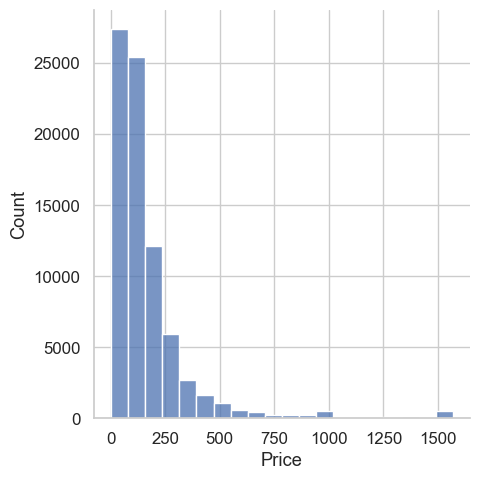

In [137]:
# Count plot for target variable
# ターゲット変数のカウントプロット
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [10, 10]})
sns.displot(gdf_selected['price'], kde=False, bins=20,).set(xlabel='Price', ylabel='Count')

array([[<Axes: title={'center': 'minimum_nights'}>,
        <Axes: title={'center': 'number_of_reviews'}>,
        <Axes: title={'center': 'reviews_per_month'}>,
        <Axes: title={'center': 'availability_365'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'lesiure'}>,
        <Axes: title={'center': 'tourism'}>,
        <Axes: title={'center': 'transportation'}>,
        <Axes: title={'center': 'mobility'}>, <Axes: >]], dtype=object)

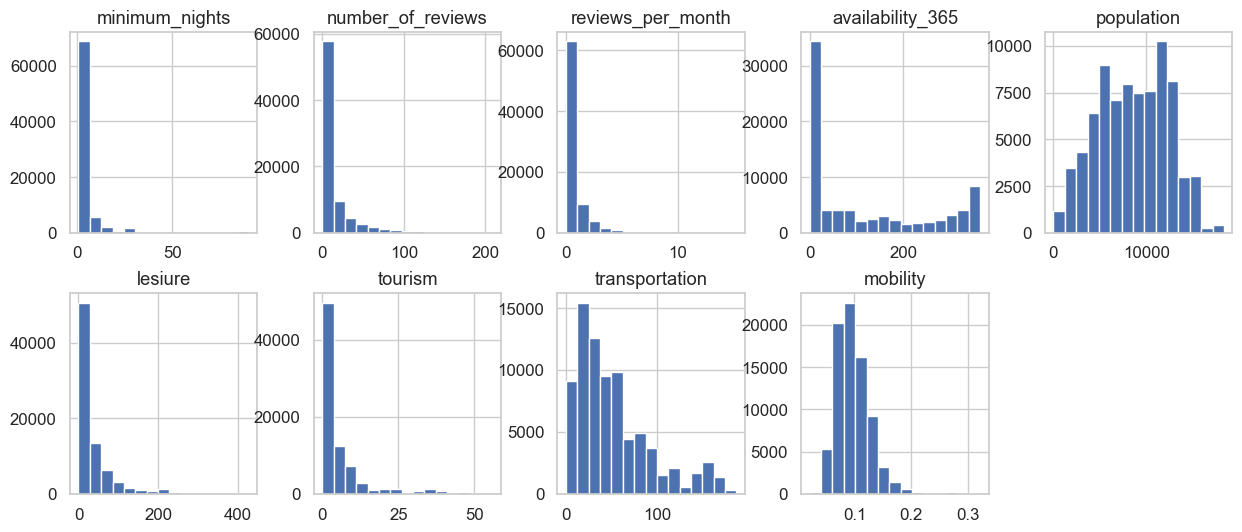

In [138]:
# Count plot for target numerical variables
# 数値変数のカウントプロット
num_len = len(numerical_variables)
cols = 5
row_fun = lambda len, cols: math.floor(len / cols) + 1 if len % cols != 0 else math.floor(len / cols)
rows = row_fun(num_len, cols)
gdf_selected[numerical_variables].hist(bins=15, figsize=(15, 6), layout=(rows, 5))

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


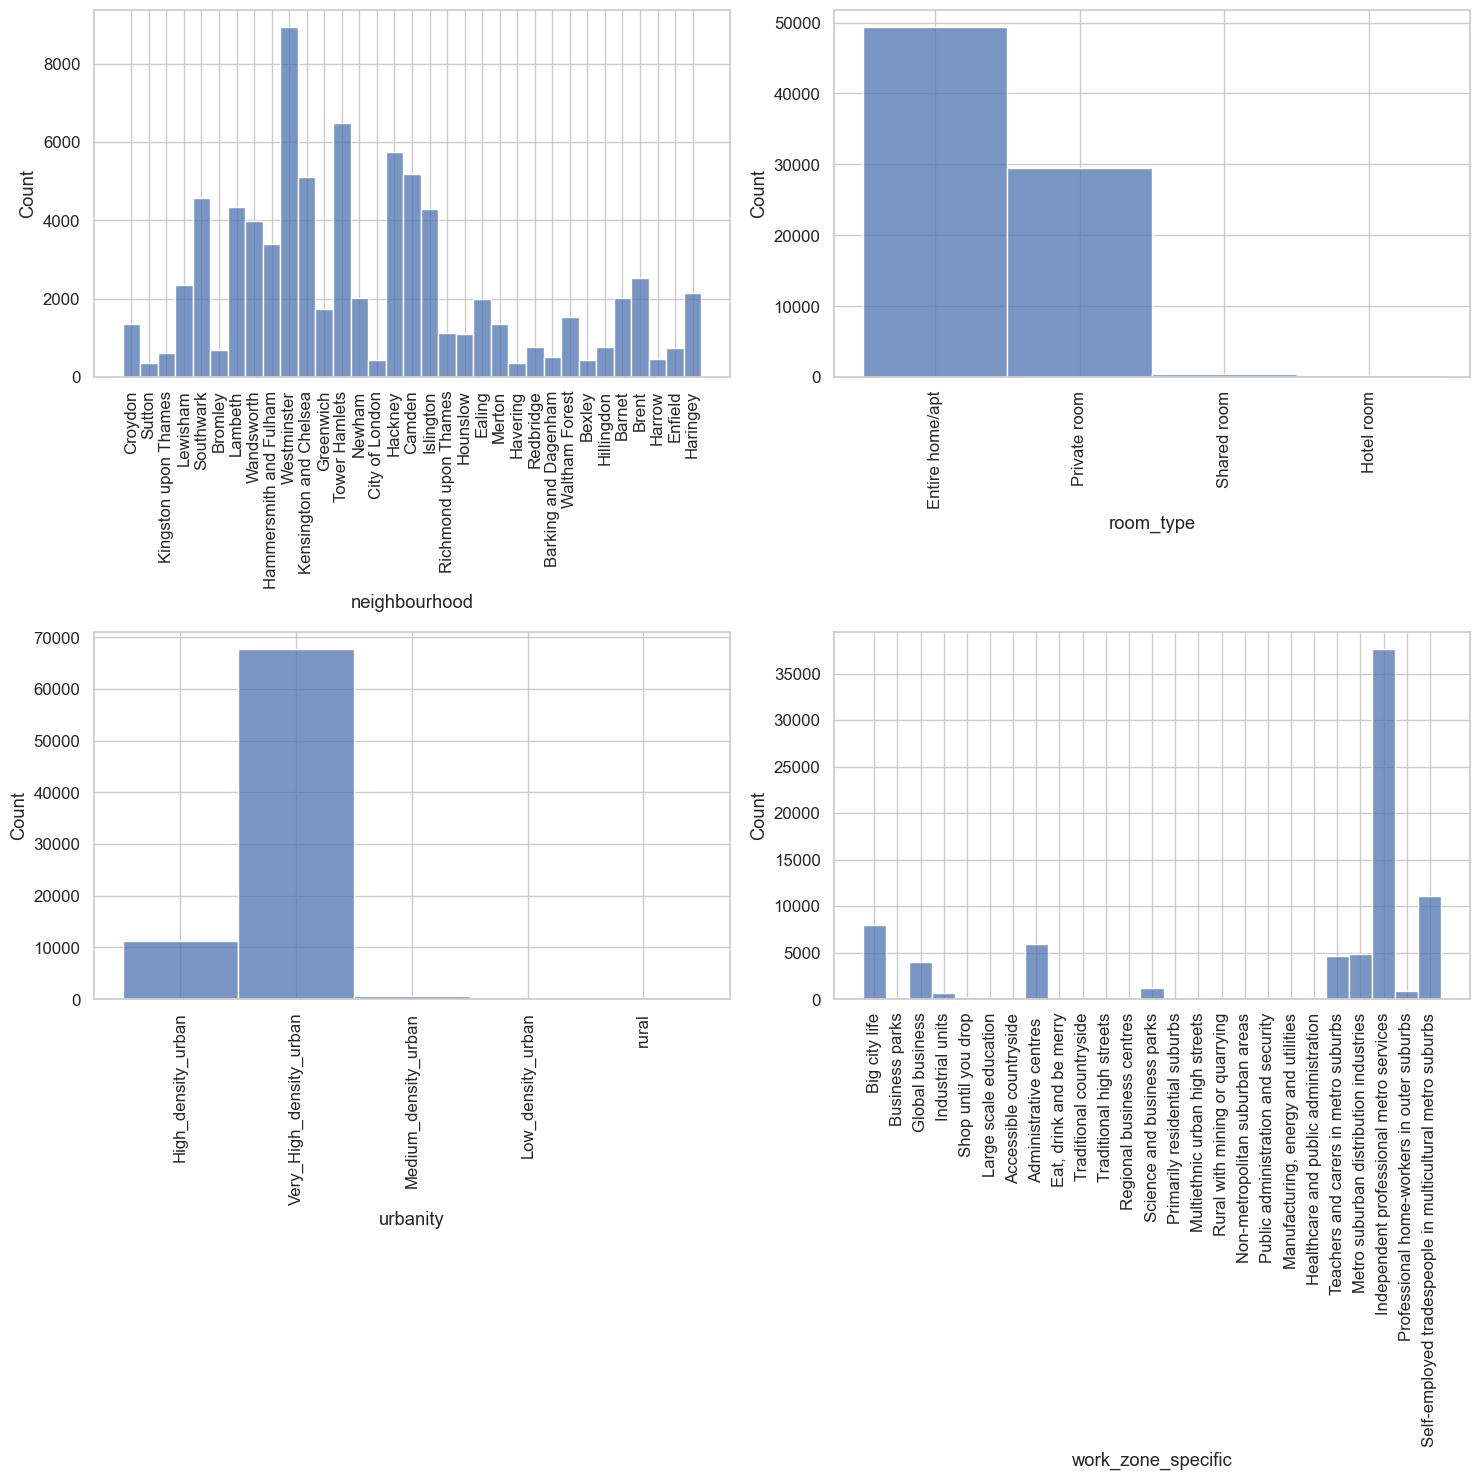

In [143]:
# Count plot for target categorical variables
# カテゴリー変数のカウントプロット

num_len = len(categorical_variables)
cols = 2
row_fun = lambda len, cols: math.floor(len / cols) + 1 if len % cols != 0 else math.floor(len / cols)
rows = row_fun(num_len, cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.ravel()
for col, ax in zip(categorical_variables, axes):
    sns.histplot(gdf_selected[col], ax=ax).set_xticklabels(
        ax.get_xticklabels(), rotation=90
    )

fig.tight_layout()
plt.show()

## Encoding

![alt text for screen readers](encoding1.png "One Hot Encoding.")

![alt text for screen readers](encoding2.png "Label Encoding.")

In [146]:
gdf_encoded = gdf_selected[categorical_variables + numerical_variables + [target]].copy()
# Display categorical features and their respective cardinality
# カテゴリカルな特徴とそれぞれのカーディナリティを表示します

high_card = []
low_card = []
for cat in categorical_variables:
    if gdf_encoded[cat].nunique() >= 15:
       high_card.append(cat)
    else:
        low_card.append(cat) 

# Nominal variable and cardinality < 15, use OneHot Encoding
# 名目変数でカーディナリティが15未満の場合、OneHotエンコーディングを使用する。
gdf_encoded = pd.get_dummies(gdf_encoded, columns=low_card, dtype=int)

# Nominal variable and cardinality >= 15, use Target Encoding
# 名目変数でカーディナリティが15を超える場合は、ターゲットエンコーディングを使用する。
encoder = ce.TargetEncoder()
for hc in high_card:
    gdf_encoded[hc] = encoder.fit_transform(gdf_encoded[hc], gdf_encoded[target])
gdf_encoded

,neighbourhood,work_zone_specific,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population,lesiure,tourism,transportation,...,price,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,urbanity_High_density_urban,urbanity_Low_density_urban,urbanity_Medium_density_urban,urbanity_Very_High_density_urban,urbanity_rural
index,,,,,,,,,,,,,,,,,,,,,
0,93.348018,247.212007,2.0,0.0,0.00,0.0,3265.981399,68.0,1.0,38.0,...,50.0,1,0,0,0,1,0,0,0,0
1,93.348018,247.212007,1.0,0.0,0.00,244.0,3265.981399,68.0,1.0,38.0,...,53.0,0,0,1,0,1,0,0,0,0
2,91.459538,247.212007,2.0,10.0,1.34,64.0,5915.986059,13.0,1.0,34.0,...,221.0,1,0,0,0,1,0,0,0,0
3,91.459538,247.212007,3.0,21.0,0.24,325.0,5915.986059,13.0,1.0,34.0,...,107.0,1,0,0,0,1,0,0,0,0
4,91.459538,247.212007,2.0,31.0,0.32,351.0,1251.641355,0.0,1.0,7.0,...,65.0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81750,103.215259,107.190459,7.0,0.0,0.00,365.0,4434.785557,0.0,1.0,13.0,...,200.0,1,0,0,0,1,0,0,0,0
81751,103.215259,107.190459,2.0,2.0,2.00,337.0,1512.703085,1.0,0.0,2.0,...,57.0,0,0,1,0,1,0,0,0,0
81752,103.215259,107.190459,2.0,0.0,0.00,338.0,1512.703085,1.0,0.0,2.0,...,80.0,0,0,1,0,1,0,0,0,0


In [147]:
# Split dataset into dependent and independent variables (X and y)
# データセットを従属変数と独立変数 (X と y) に分割する
X = gdf_encoded.drop("price", axis=1).copy()
y = gdf_encoded["price"].copy()

# Split X and y data into train and test data 80/20
# XとYのデータを訓練データとテストデータに分ける 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=14, test_size=.2)

# Models

## XGBOOST

### Default Model

In [148]:
# Create model instance
# モデルのインスタンスを作成する
xgb_model = xgb.XGBRegressor(
    seed=39,
    eval_metric=["mae", "rmse"],
    device='cuda:0',
    predictor = 'gpu_predictor'
)

### Optimized Model

In [149]:
# Create model instance
# モデルのインスタンスを作成する
optimized_parameters = {
    'n_estimators': 100,
    'colsample_bytree': 0.5,
    'gamma': 0.1,
    'learning_rate': 0.05,
    'max_depth': 12,
    'min_child_weight': 1
}
xgb_model = xgb.XGBRegressor(
    **optimized_parameters,
    seed=39,
    eval_metric=["mae", "rmse"],
    device='cuda:0',
    predictor = 'gpu_predictor'
)

In [150]:
# Train the model
# モデルをトレーニングする
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, verbose=0, eval_set=eval_set)

[16:42:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             device='cuda:0', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['mae', 'rmse'], gamma=0.1,
             gpu_id=0, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=12, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             predictor='gpu_predictor', random_state=39, reg_alpha=0, ...)

In [155]:
# Make predictions on our test data
# テストデータで予測を行う
preds = xgb_model.predict(X_test)
predictions = [round(value) for value in preds]
print("Predicted prices:", predictions[0:5])
print("Actual prices:   ", [round(value) for value in list(y_test)][0:5])

Predicted prices: [290, 47, 126, 218, 198]
Actual prices:    [278, 45, 88, 75, 150]


In [157]:
# Evaluate model
# モデルを評価する

# Higher is better
# R2 score / R2スコア
print("R^2 :", r2_score(y_test, predictions))
# Adjusted R2 / 調整後R2
print("Adjusted R^2 :", 1 - (1-xgb_model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))
print()
# Less is better
# Mean Average Error / 平均平均誤差
print("MAE :", mean_absolute_error(y_test,predictions))
# Root Mean Squared Error / 平均二乗誤差
print("RMSE:", np.sqrt(mean_squared_error(y_test, predictions)))

R^2 : 0.5597603864678389
Adjusted R^2 : 0.7710407927436771

MAE : 69.04458278312268
RMSE: 131.02921706754887


## Validation & Plotting

In [159]:
# Calculate the shap values (GPU reccomended)
# シャップ値を計算する（GPU推奨）
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
expected_value = explainer.expected_value

if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: 167.9075927734375


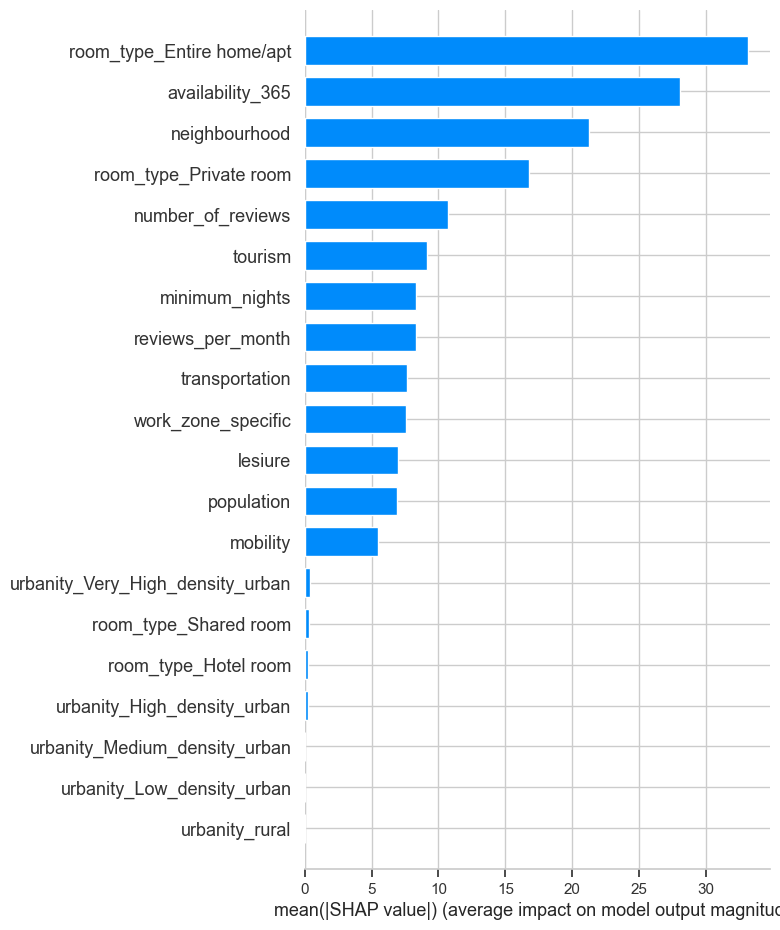

In [160]:
# Create summary plot, showing the most impactful features
# 最もインパクトのある特徴を示すサマリープロットを作成する
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


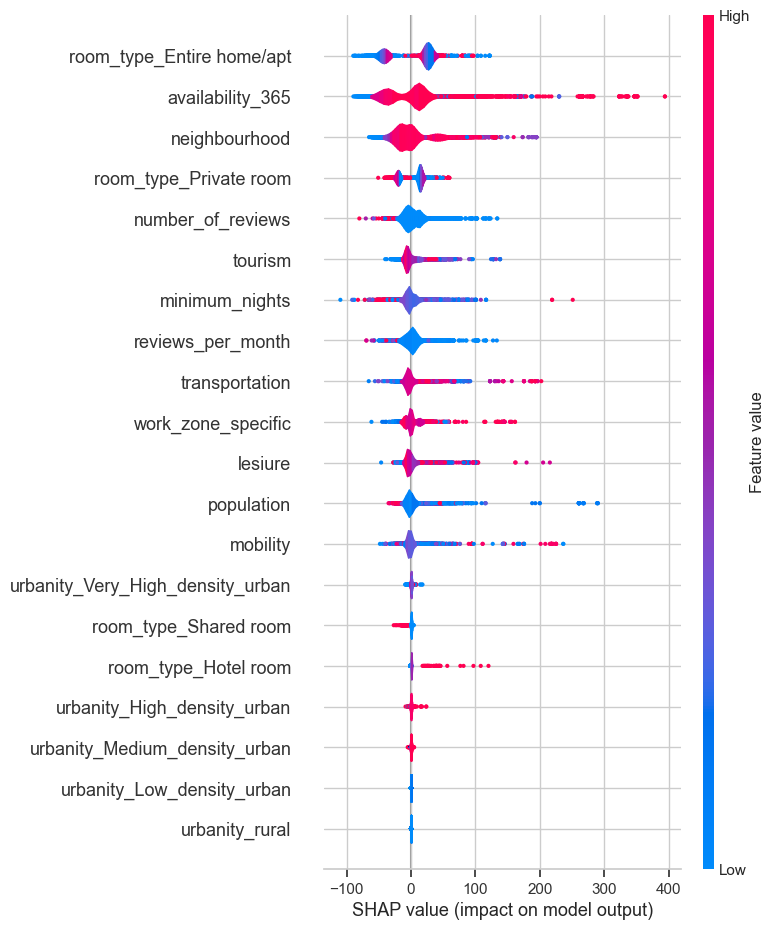

In [161]:
# Same plot as above but this time we can see the distribution of values
# 上と同じプロットだが、今回は値の分布を見ることができる
shap.summary_plot(shap_values, X_test, plot_type='violin', show=True)

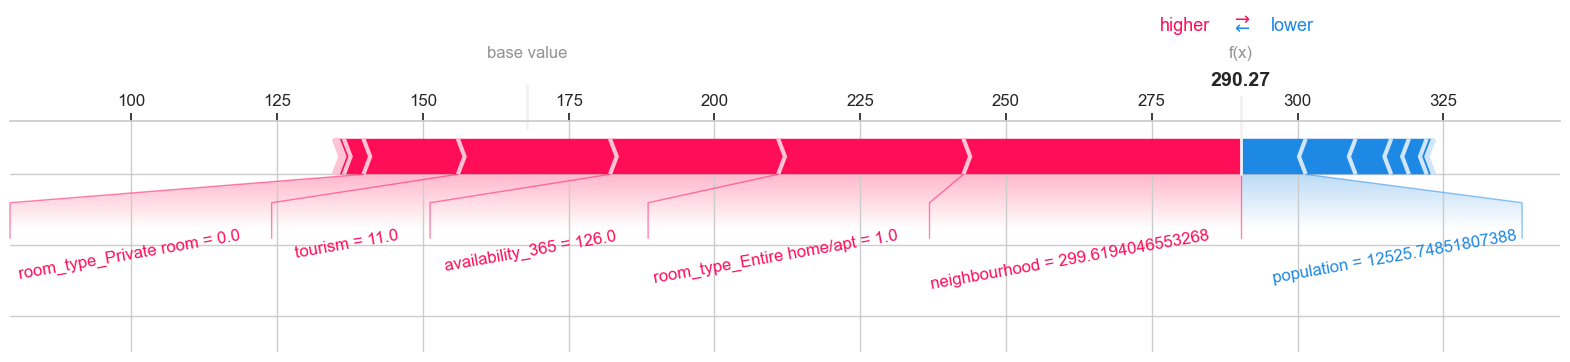

In [165]:
# Create force plot for the same predictions, a different way of visualizing feature impact
# 同じ予測に対してフォースプロットを作成し、特徴の影響を別の方法で視覚化する
features = X_test.iloc[0:1]
shap_values = explainer.shap_values(features)

shap.force_plot(expected_value, shap_values, features, text_rotation=10, matplotlib=True)

# Prediction

In [167]:
# Make predictions and joined them back to test data
# 予測を立て、それをテストデータに結びつける
gdf_out = X_test.copy()
gdf_out["price_predicted"] = xgb_model.predict(X_test)
gdf_out = gdf_out.merge(gdf_load, left_on="index", right_on="index")[
    ["h3", "price", "price_predicted"]
]
gdf_out.reset_index(drop=True, inplace=True)

# Upload result to our Carto account and overwrite same table if already present
# 結果をCartoアカウントにアップロードし、同じテーブルが存在する場合は上書きする
job_config = bigquery.LoadJobConfig(schema=[], write_disposition="WRITE_TRUNCATE")
carto_dw_client.load_table_from_dataframe(
    gdf_out,
    f"{cdw_dataset}.shared_us.london_listings_2023_predicted",
    job_config=job_config,
).result()

LoadJob<project=carto-dw-ac-zn8l36fh, location=US, id=39627491-e74d-408c-8188-726f15caf90e>

In [168]:
# List tables again and see if out new table is there
# テーブルを再度リストアップし、新しいテーブルがあるかどうかを確認する
dataset_id = 'shared_us'
tables = carto_dw_client.list_tables(dataset_id)

print("Tables contained in '{}':".format(dataset_id))
for table in tables:
    print("{}.{}.{}".format(table.project, table.dataset_id, table.table_id))

Tables contained in 'shared_us':
carto-dw-ac-zn8l36fh.shared_us.london_listings_2023
carto-dw-ac-zn8l36fh.shared_us.london_listings_2023_joined
carto-dw-ac-zn8l36fh.shared_us.london_listings_2023_predicted


In [179]:
# Create final map to visualize our predictions
# 予測を視覚化する最終マップを作成する
pdkc.register_carto_layer()

layer = pdk.Layer(
    "CartoLayer",
    data=f"SELECT h3, price_predicted, price FROM `{cdw_dataset}.shared_us.london_listings_2023_predicted`",
    type_=pdkc.MapType.QUERY,
    connection=pdkc.CartoConnection.CARTO_DW,
    credentials=pdkc.get_layer_credentials(carto_auth),

    aggregation_exp=pdk.types.String("avg(price_predicted) as price_predicted"),
    aggregation_res_level=8,
    geo_column=pdk.types.String("h3"),

    get_fill_color=pdkc.styles.color_bins("price_predicted",[0, 100, 200, 300, 400, 500], "Sunset"),
    opacity=0.4,


    get_elevation='properties.price_predicted',
    elevation_scale=10,

    stroked=False,
    filled=True,
    extruded=True,
    wireframe=True,
    auto_highlight=True,
    pickable=True
)

tooltip = {"html": "<b>H3 Index:</b> {id} <br /><b>Predicted Price:</b> {price_predicted}"}

view_state = pdk.ViewState(
    latitude=51.50071697877869,
    longitude=-0.12461158468895285,
    zoom=8,
    pitch=45,
    bearing=0
  )

pdk.Deck(layer, map_style=pdk.map_styles.DARK, tooltip=tooltip, initial_view_state=view_state).to_html(iframe_height=800)

In [176]:
# Create final map to visualize our predictions
# 予測を視覚化する最終マップを作成する
pdkc.register_carto_layer()

layer = pdk.Layer(
    "CartoLayer",
    data=f"SELECT h3, price FROM `{cdw_dataset}.shared_us.london_listings_2023_predicted`",
    type_=pdkc.MapType.QUERY,
    connection=pdkc.CartoConnection.CARTO_DW,
    credentials=pdkc.get_layer_credentials(carto_auth),

    aggregation_exp=pdk.types.String("avg(price) as price"),
    aggregation_res_level=8,
    geo_column=pdk.types.String("h3"),

    get_fill_color=pdkc.styles.color_bins("price",[0, 100, 200, 300, 400, 500], "Sunset"),
    opacity=0.4,

    get_elevation='properties.price',
    elevation_scale=10,

    stroked=False,
    filled=True,
    extruded=True,
    wireframe=True,
    auto_highlight=True,
    pickable=True
)

tooltip = {"html": "<b>H3 Index:</b> {id} <br /><b>Actual Price:</b> {price}"}

view_state = pdk.ViewState(
    latitude=51.50071697877869,
    longitude=-0.12461158468895285,
    zoom=8,
    pitch=45,
    bearing=0
  )

pdk.Deck(layer, map_style=pdk.map_styles.DARK, tooltip=tooltip, initial_view_state=view_state).to_html(iframe_height=800)

# Appendix

## Model Optimization

In [ ]:
# Initialize default model and choose the combination of hyperparameters to use during GridSearch
# デフォルトモデルを初期化し、グリッドサーチ時に使用するハイパーパラメータの組み合わせを選択する
reg_model = xgb.XGBRegressor(gpu_id=0, tree_method='gpu_hist', predictor='gpu_predictor')
grid = {
    "learning_rate": [0.05, 0.1],
    "max_depth": [8, 10, 12],
    "min_child_weight": [1, 3],
    "gamma":[0.0, 0.1],
    "colsample_bytree":[0.5, 1]
}

# Run the GridSearch (around 2 minutes, GPU session reccomended)
# グリッドサーチの実行（2分程度、GPUセッション推奨）
grid_search = GridSearchCV(
            estimator=reg_model,
            param_grid=grid,
            cv=2,
            scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearch
# GridSearchによって見つかった最適なパラメータを表示する
print(f"Best parameters: {grid_search.best_params_}")

# Print a few of the many runs made by during the GridSearch
# GridSearch中に実行された多くのランのうちのいくつかを表示する
pd.DataFrame(grid_search.cv_results_).head()



## Data Observatory Data Visualization / データ・オブザーバートリー

In [ ]:
# Get a list of all subscribed tables again
# 再びすべての購読テーブルのリストを取得する
get_subscriptions_q = f"""
  CALL `carto-un`.carto.DATAOBS_SUBSCRIPTIONS('{cdo_dataset}',"dataset_license = 'Public data'");
  """

subs_df = carto_dw_client.query(get_subscriptions_q).result().to_dataframe(create_bqstorage_client=False)
display(subs_df)

# Extract table ID and associated geography table if present
# テーブルIDと関連する地理テーブルがあればそれを抽出する。
dataset_id, geography_id = subs_df.query(
    "dataset_slug == 'cdrc_residential_6d0ab56e'"
)[["dataset_table", "associated_geography_table"]].values.ravel()

In [ ]:
# Register CartoLayer in pydeck
# pydeckにCartoLayerを登録する。
pdkc.register_carto_layer()

# Render first CartoLayer CartoLayer
# 最初の CartoLayer CartoLayer をレンダリングする。
layer_one = pdk.Layer(
    "CartoLayer",
    data = f"""SELECT y2016, geom
    FROM `{cdo_dataset}.{dataset_id}` d
    JOIN `{cdo_dataset}.{geography_id}` g
    ON d.geoid = g.geoid""",
    geo_column=pdk.types.String("geom"),
    type_=pdkc.MapType.QUERY,
    connection=pdkc.CartoConnection.CARTO_DW,
    credentials=pdkc.get_layer_credentials(carto_auth),
    get_fill_color=pdkc.styles.color_bins("y2016",[0, 0.07, 0.08, 0.09, 0.1, 0.11, 1], "Emrld"),
    get_line_color=[0, 0, 0, 100],
    line_width_min_pixels=1,
    opacity=0.5,
    pickable=True,
    stroked=True,
    )

# Add tooltip to show values on map
# 地図上に値を表示するツールチップを追加する
tooltip = {
    "html": "Mobility: <b>{y2016}</b>",
    "style": {
        "background": "grey",
        "color": "white",
        "font-family":
        '"Helvetica Neue", Arial',
        "z-index": "10000"
    },
}

# Set initial viewing location/zoom/angle
# 初期表示位置/ズーム/アングルを設定する
view_state = pdk.ViewState(
    latitude=51.50071697877869, longitude=-0.12461158468895285, zoom=8
)

# Initialize map
# マップの初期化
pdk.Deck(
    layer_one,
    tooltip = tooltip,
    initial_view_state=view_state,
    map_style=pdk.map_styles.LIGHT,
).to_html(iframe_height = 800)